# A Concrete Truth: Predicting concrete strength and carbon footprint

## 1) Installing Dependencies

In [2]:
# essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

# linear model
from sklearn.linear_model import LinearRegression

# ensemble models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

# neural networks
from sklearn.neural_network import MLPRegressor
from keras import models, layers, optimizers, losses, metrics, Sequential


We use this power set function to consider relevant features.

In [21]:
# This function was modified from stackexchange user hughdbrown 
# at this link, 
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

# This returns the power set of a set minus the empty set
def powerset(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
        
    return power_set[1:]


## 2) Exploratory Data Analysis

In [166]:
concrete = pd.read_csv('data/concrete.csv')
co2 = pd.read_csv('data/co2.csv')

concrete['co2_lower'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'lower_bound'].values[0] for col in concrete.columns[:7]])
concrete['co2_upper'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'upper_bound'].values[0] for col in concrete.columns[:7]])
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
 9   co2_lower     1030 non-null   float64
 10  co2_upper     1030 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 88.6 KB


We first split the data and analyze the training set.

In [171]:
concrete_train, concrete_test = train_test_split(concrete,
                                                 shuffle=True,
                                                 random_state=487)

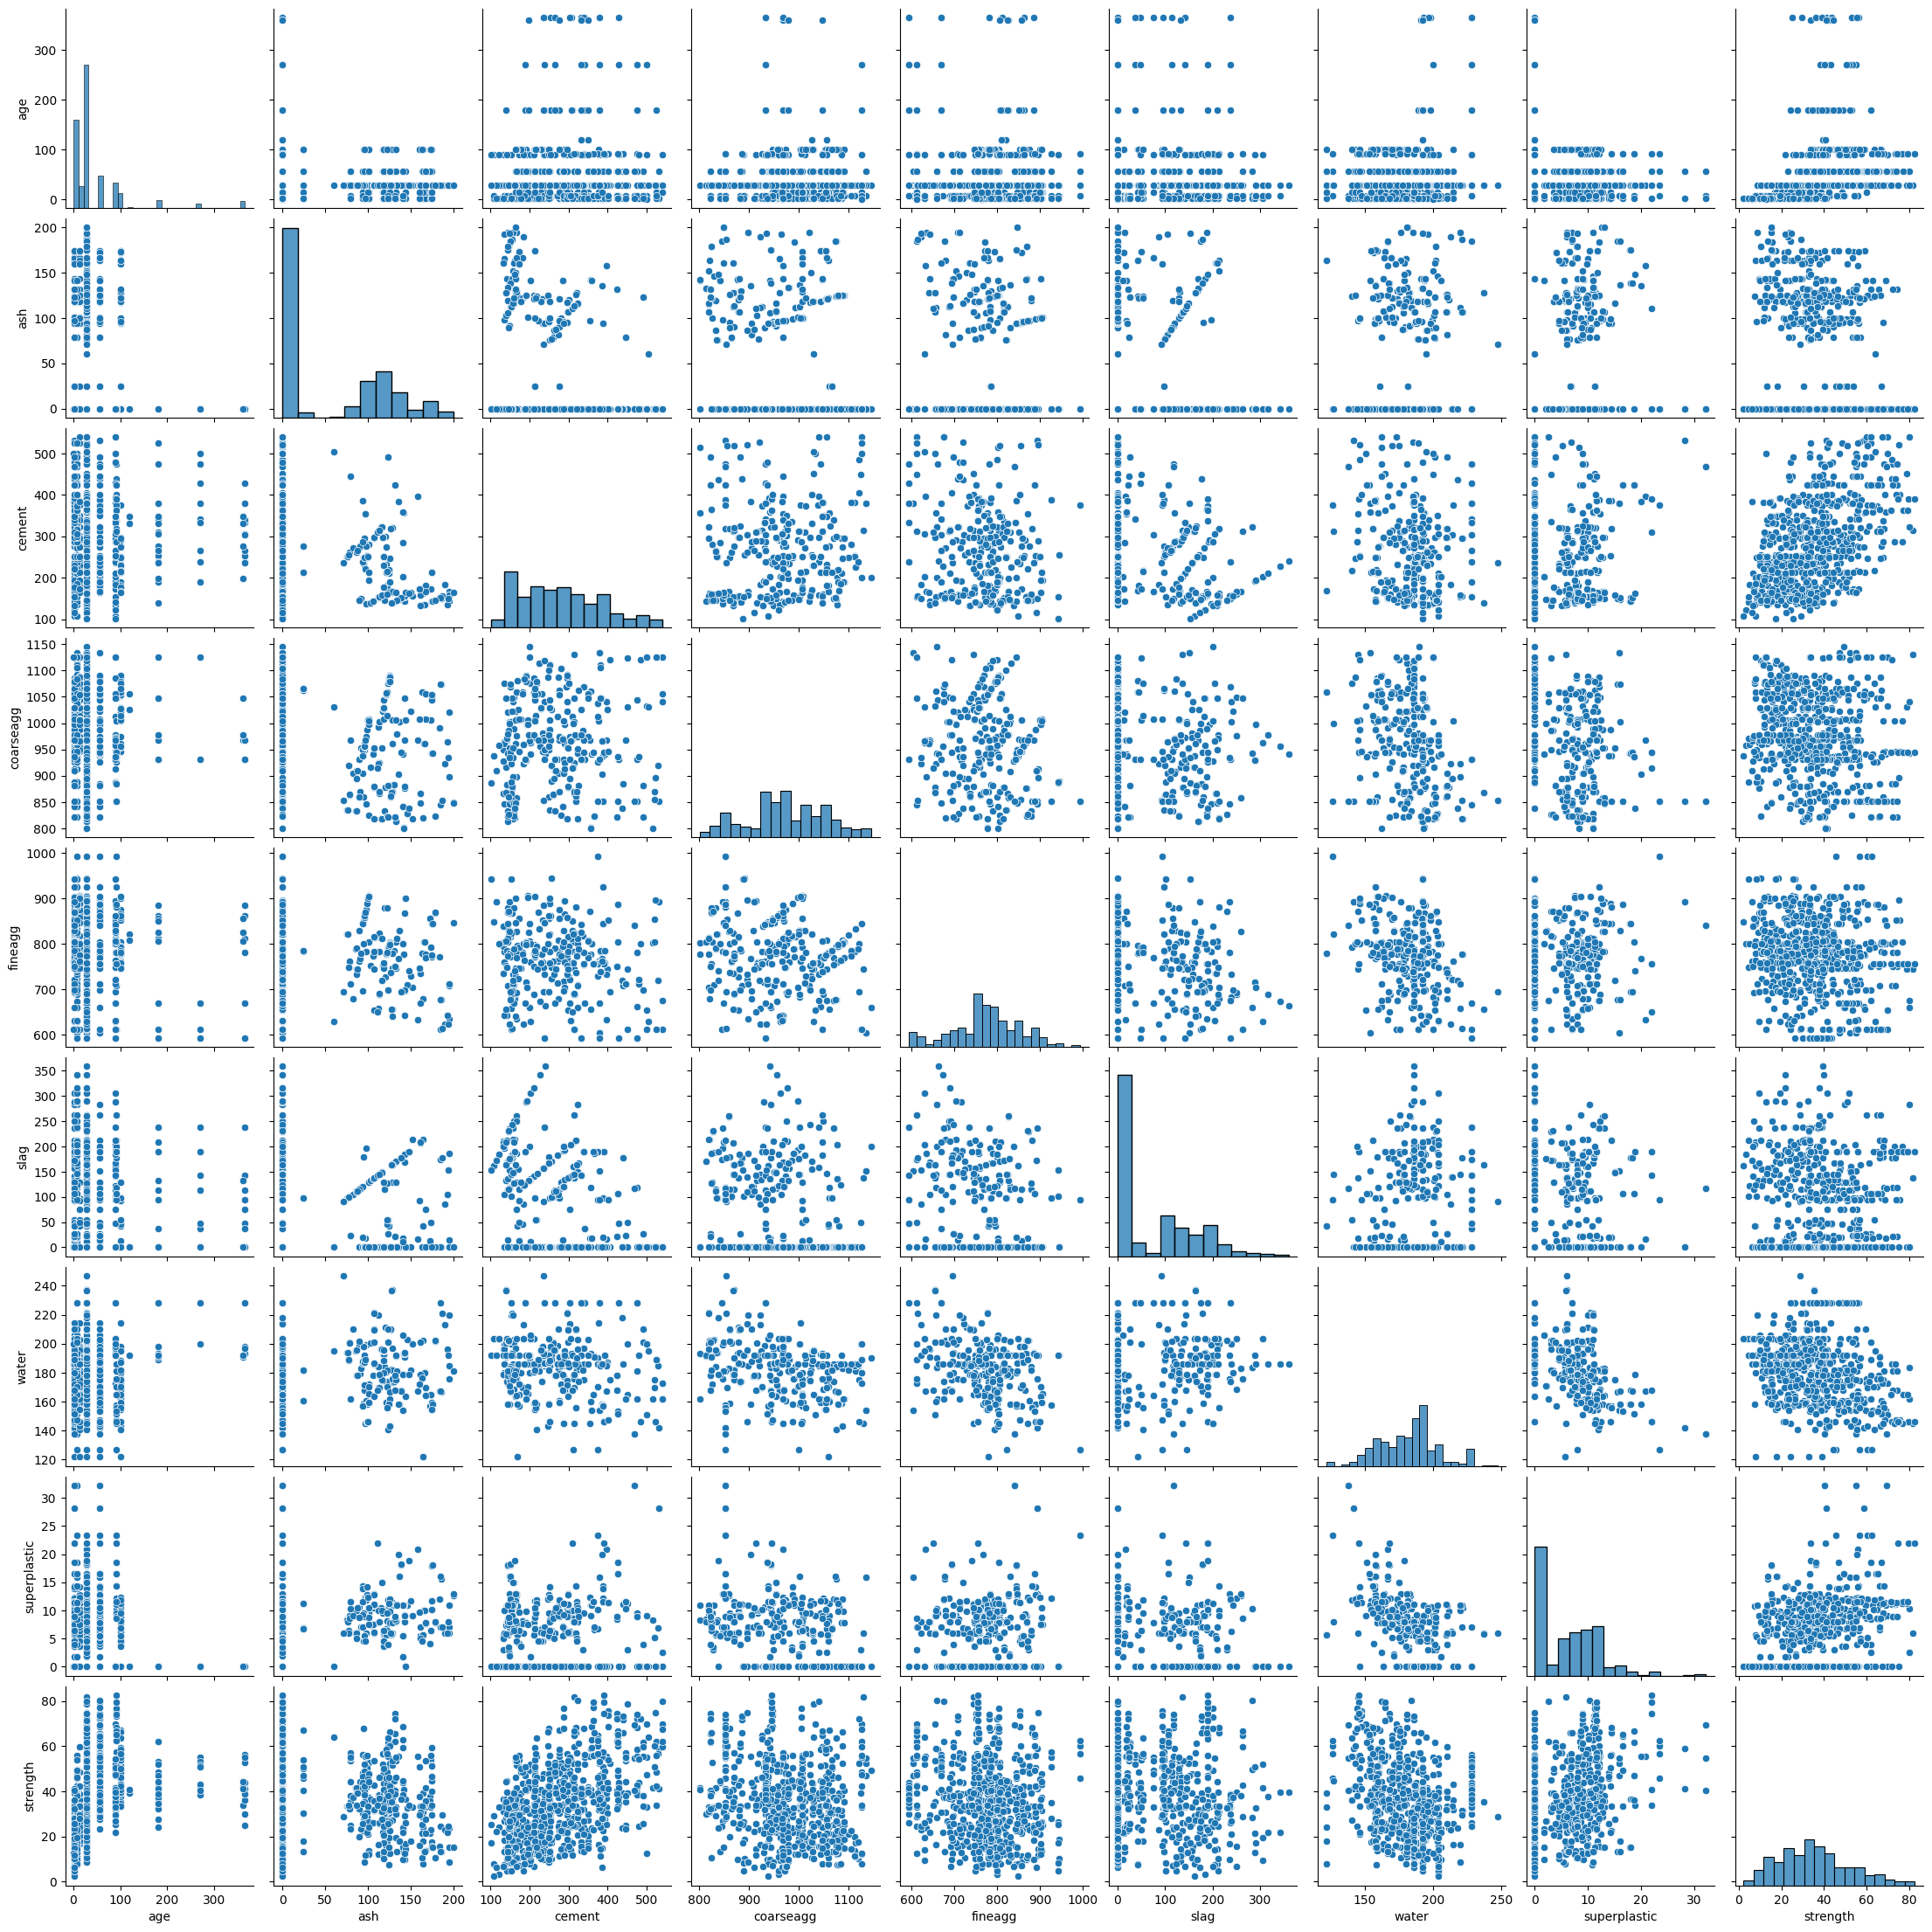

In [134]:
sns.pairplot(concrete_train[['age','ash','cement','coarseagg','fineagg','slag','water','superplastic','strength']])
plt.show()

If we first focus on the age, we notice it is strangely distributed.

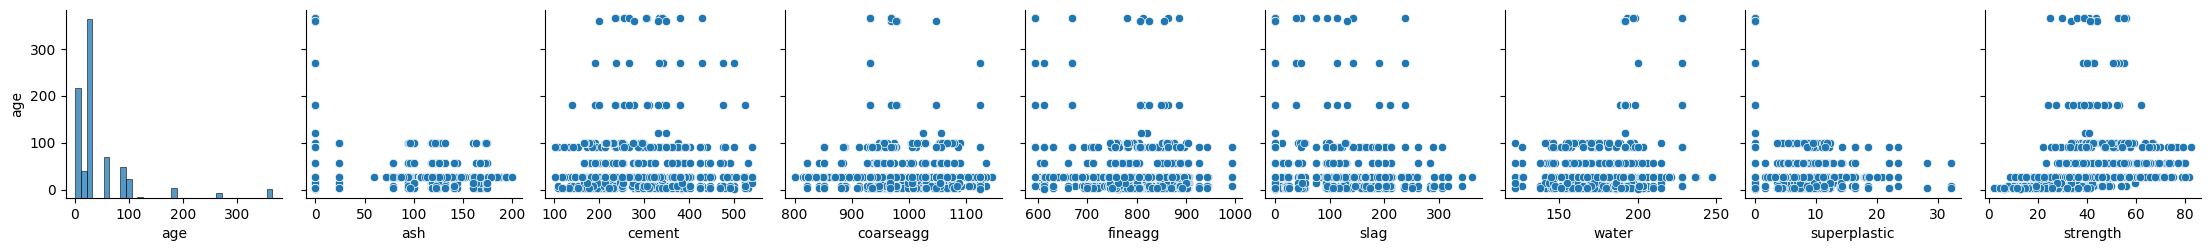

In [136]:
sns.pairplot(concrete_train,
x_vars=['age', 'ash','cement','coarseagg','fineagg','slag','water','superplastic','strength'],
y_vars='age')
plt.show()

It looks like the data with age greater than 120 days is both small and not representative of the the data as a whole. So we will remove it from our dataframe.

This is a reasonable choice to make since studies have shown concrete reaches almost maximum strength within 14-28 days.

In [167]:
concrete = concrete[concrete['age'] < 120]

The data now looks better distributed.

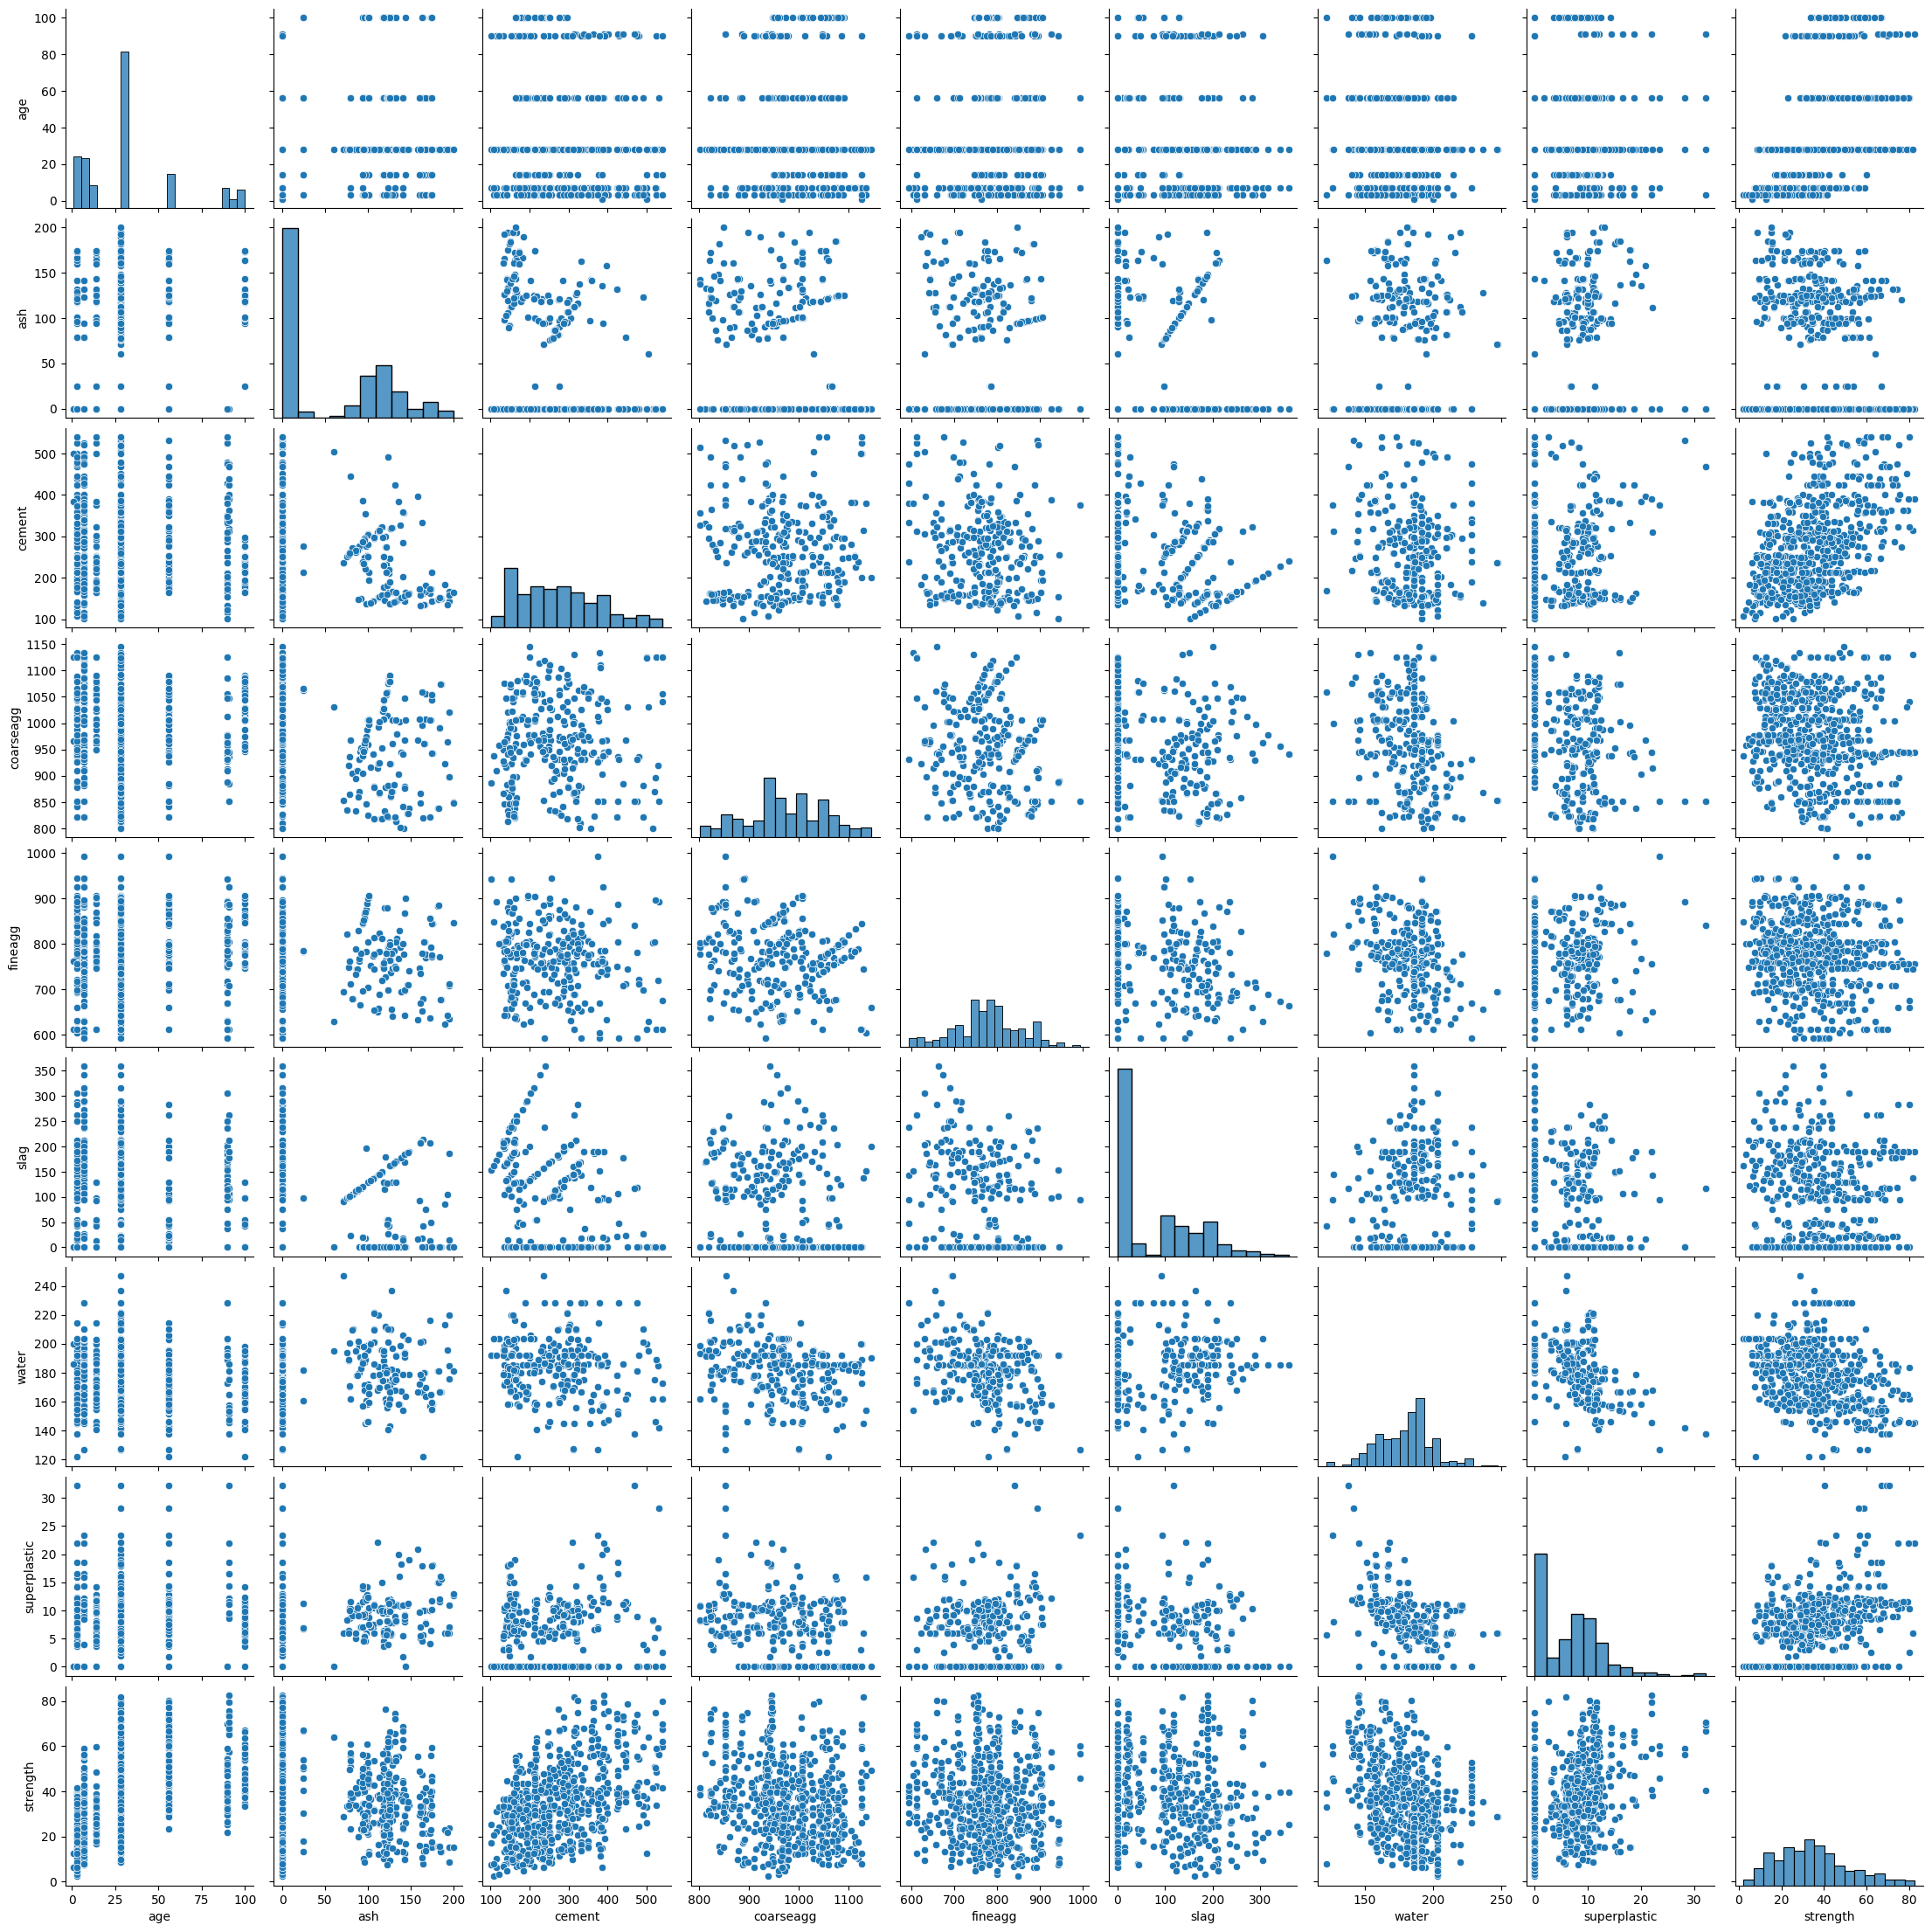

In [33]:
sns.pairplot(concrete_train[['age','ash','cement','coarseagg','fineagg','slag','water','superplastic','strength']])
plt.show()

We also note that the ash and slag features are strangely balanced, with a large proportion having value 0. Indeed, around a quarter of datapoints have no ash or slag, a quarter have one and not the other, and so on. We may be able to improve our models by looking at each of the four cases individually, but this is beyond the scope of our project.

### Exponential model for age

We know from the literature that the strength of concrete is roughly M - Ce^(-kt), so we try to find the best fit.

To find the best factor k, we make a function that performs linear regression given a set of features.

In [137]:
def slr_cv(data, features, n_jobs, n_splits=5, rs=97, print_best=True):
    
    grid_cv = GridSearchCV(LinearRegression(copy_X=True), 
                           param_grid={'n_jobs': n_jobs},
                              scoring = 'neg_mean_squared_error', 
                              cv = 5) 

    ## you fit it just like a model
    grid_cv.fit(data[features], data['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv


Now we test the regression given different exponential factors.

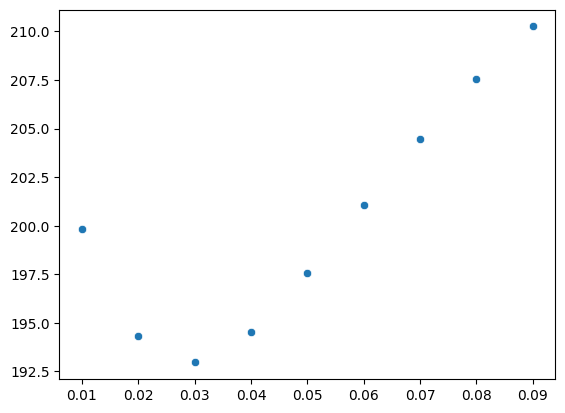

In [172]:
exp_mses = []
for factor in np.arange(.01, .1, .01):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    exp_mses.append(-slr_cv(concrete_train, ['exp_age'], [1], print_best=False).best_score_)

sns.scatterplot(x=np.arange(.01, .1, .01),
y=exp_mses)

plt.show()

This is obviously making an impact, so we try over all possible features.

In [173]:
features = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'exp_age']

for factor in np.arange(.01, .1, .01):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    print(factor, -slr_cv(concrete_train, features, [1], print_best=False).best_score_)

0.01 57.533044822296105
0.02 50.65740976575569
0.03 47.288714707711634
0.04 46.69050378370291
0.05 47.77552683523926
0.060000000000000005 49.67011126170889
0.06999999999999999 51.83720431919117
0.08 53.99918758481631
0.09 56.03533389609764


In [153]:
features = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'exp_age']

for factor in np.arange(.03, .05, .001):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    print(factor, -slr_cv(concrete_train, features, [1], print_best=False).best_score_)

0.03 50.688101128159
0.031 50.39393367007619
0.032 50.13743168583202
0.033 49.91632568292859
0.034 49.72848336366267
0.035 49.571894762305895
0.036000000000000004 49.444660181118465
0.037000000000000005 49.34498036506663
0.038000000000000006 49.271148459503294
0.03900000000000001 49.22154338111604
0.04000000000000001 49.19462430326431
0.04100000000000001 49.188926015021096
0.04200000000000001 49.203054960979735
0.04300000000000001 49.23568580798188
0.04400000000000001 49.285558416862976
0.04500000000000001 49.35147512333284
0.04600000000000001 49.43229825323498
0.047000000000000014 49.526947814512916
0.048000000000000015 49.63439932195692
0.049000000000000016 49.753681721804114
0.05000000000000002 49.88387539200103


In [174]:
features = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'exp_age']

best_features = []
for factor in np.arange(.01, .1, .01):
       concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
       feature_mses = []
       for feature in powerset(features[:-1]):
              feature.append('exp_age')

              feature_mses.append(-slr_cv(concrete_train, feature, [1], print_best=False).best_score_)

       print(factor, np.min(feature_mses))
       print(powerset(features[:-1])[np.argmin(feature_mses)] + ['exp_age'])



0.01 57.45458426287492
['cement', 'slag', 'ash', 'water', 'superplastic', 'exp_age']
0.02 50.65740976575569
['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']
0.03 47.288714707711634
['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']
0.04 46.69050378370291
['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']
0.05 47.77552683523926
['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']
0.060000000000000005 49.67011126170889
['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']
0.06999999999999999 51.83720431919117
['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']
0.08 53.99603243549977
['cement', 'slag', 'ash', 'water', 'coarseagg', 'fineagg', 'exp_age']
0.09 56.02883361850265
['cement', 'slag', 'ash', 'water', 'coarseagg', 'fineagg', 'exp_age']


As we can see, the linear model works best using all features, so we will use all features from now on. Now we refine.

In [175]:
best_mses = []
for factor in np.arange(.03, .05, .001):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    best_mses.append(-slr_cv(concrete_train, features, [1], print_best=False).best_score_)

print(np.arange(.03, .05, .001)[np.argmin(best_mses)], np.min(best_mses))

0.038000000000000006 46.64176195674095


So we pick the factor k = .038.

In [176]:
concrete_train['exp_age'] = np.exp(-.038 * concrete_train['age'])

We can verify if the relation is roughly linear.

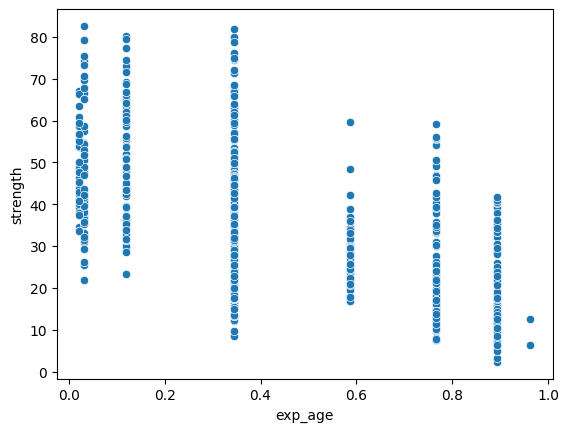

In [177]:
sns.scatterplot(data=concrete_train,
                x='exp_age',
                y='strength')

plt.show()

## 3) Model Selection


Our base model is the expected value of strength.

We will compare the following models:
1. `LinearRegression`, our baseline model
2. `RandomForestRegressor`, which serves as a base among ensemble models
3. `XGBRegressor`
4. `HistGradientBoostingRegressor`
5. `MLPRegressor`, which serves as a base for neural networks
6. `Keras`

The linear model serves as the baseline and is already a vast improvement over the expected value. As we will see, Random Forest has some success, which motivated us to try some generally more effective ensemble models. Finally, we consider some neural networks and see how good the are after some basic tuning.

We will compare the errors of all models using the same cross-validation at the end of this section.

As mentioned above, we apply these models to all features, although one could do a more rigorous comparison using all possible feature combinations.

In [64]:
concrete = pd.read_csv('data/concrete.csv')
co2 = pd.read_csv('data/co2.csv')

concrete['exp_age'] = np.exp(-.038 * concrete['age'])

concrete['co2_lower'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'lower_bound'].values[0] for col in concrete.columns[:7]])
concrete['co2_upper'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'upper_bound'].values[0] for col in concrete.columns[:7]])

concrete = concrete[concrete['age'] < 120]

concrete_train, concrete_test = train_test_split(concrete,
                                                 shuffle=True,
                                                 random_state=487)

features = ['cement', 'ash', 'slag', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']

### 3.1) Linear Model

Since we used the linear model to do exploratory data analysis, there is nothing further to tune.

We can compare the linear model's mean squared error with that of the expected value to show that it is a good even for a base.

In [184]:
ev = np.mean(concrete_train['strength']) * np.ones(len(concrete_train))

print(f'Expected value: {mean_squared_error(y_true=concrete_train.strength, y_pred = ev)}') 
print(f'Linear model: {-slr_cv(concrete_train, features, [1], print_best=False).best_score_}')

Expected value: 292.7020452557127
Linear model: 46.64176195674095


### 3.2) Random Forest

Based on our modeling, the most significant parameters for random forest are max_depth and n_estimators. We do some basic grid searches to get a good candidate.

In [193]:
def rf_grid(data, features, max_depths ,n_estimators, print_best=True):

    grid_cv = GridSearchCV(RandomForestRegressor(), 
                              param_grid = {'max_depth':max_depths, 
                                            'n_estimators':n_estimators}, 
                              scoring = 'neg_mean_squared_error',
                              cv = 5) 

    grid_cv.fit(data[features], data['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv

In [194]:
max_depths = [10, 15, 20]
n_estimators = [100, 300, 500]


rf_cv = rf_grid(concrete_train, features , max_depths,n_estimators, print_best=True)

The best set of parameters is {'max_depth': 20, 'n_estimators': 500}
The best set of score is 29.32362327228433


In [195]:
max_depths = [15, 17, 19]
n_estimators = [400, 500, 600]


rf_cv = rf_grid(concrete_train, features , max_depths,n_estimators, print_best=True)

The best set of parameters is {'max_depth': 15, 'n_estimators': 500}
The best set of score is 29.39680884051369


In [225]:
best_rf_params = {'max_depth': 17, 'n_estimators': 500}

### 3.3) XGBoost

For XGBoost, we also include the parameter tree_methods.

In [196]:
def xgb_grid(data, features, max_depths, n_estimators, tree_methods, print_best=True):

    grid_cv = GridSearchCV(XGBRegressor(),
                              param_grid = {'max_depth':max_depths, 
                                            'n_estimators':n_estimators,
                                            'tree_method': tree_methods}, 
                              scoring = 'neg_mean_squared_error', 
                              cv = 5) 

    ## you fit it just like a model
    grid_cv.fit(data[features], data['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv

In [197]:
max_depths = np.arange(2, 6)
n_estimators = np.arange(500, 2001, 500)
tree_methods = ['approx', 'hist', 'exact']



grid_cv = xgb_grid(concrete_train, features, max_depths, n_estimators, tree_methods, print_best=True)

The best set of parameters is {'max_depth': 2, 'n_estimators': 1000, 'tree_method': 'approx'}
The best set of score is 19.6496876659562


In [205]:
max_depths = [2]
n_estimators = np.arange(700, 1401, 100)
tree_methods = ['approx']



xgb_cv = xgb_grid(concrete_train, features, max_depths, n_estimators, tree_methods, print_best=True)

The best set of parameters is {'max_depth': 2, 'n_estimators': 1200, 'tree_method': 'approx'}
The best set of score is 19.640115527493624


The graph of mses indicates these are good parameter choices.

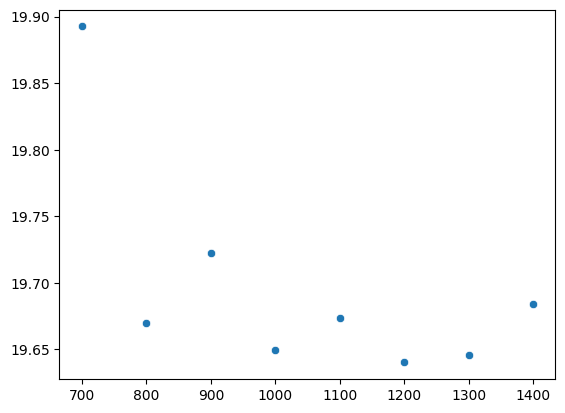

In [206]:
mses = -xgb_cv.cv_results_['mean_test_score']
sns.scatterplot(x=n_estimators,
y=mses)

plt.show()

In [224]:
best_xgb_params = {'max_depth': 2, 'n_estimators': 1200, 'tree_method': 'approx'}


### 3.4) Histogram-based Gradient Boosting

In [207]:
def hgb_grid(data, features, max_depths, max_iters, learning_rates, print_best=True):

    grid_cv = GridSearchCV(HistGradientBoostingRegressor(),
                              param_grid = {'max_depth':max_depths, 
                                            'max_iter':max_iters,
                                            'learning_rate': learning_rates}, 
                              scoring = 'neg_mean_squared_error', 
                              cv = 5) 

    ## you fit it just like a model
    grid_cv.fit(data[features], data['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv

In [209]:
max_depths = np.arange(2, 6)
max_iters = np.arange(500, 1501, 500)
learning_rates = [.01, .1, .2]

hgb_grid(concrete_train, features, max_depths, max_iters, learning_rates, print_best=True)

The best set of parameters is {'learning_rate': 0.2, 'max_depth': 5, 'max_iter': 500}
The best set of score is 21.7805034040327


GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': array([2, 3, 4, 5]),
                         'max_iter': array([ 500, 1000, 1500])},
             scoring='neg_mean_squared_error')

In [210]:
max_depths = [5]
max_iters = np.arange(200, 800, 100)
learning_rates = [.2, .3, .4]

hgb_grid(concrete_train, features, max_depths, max_iters, learning_rates, print_best=True)

The best set of parameters is {'learning_rate': 0.2, 'max_depth': 5, 'max_iter': 400}
The best set of score is 21.757044090709428


GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(),
             param_grid={'learning_rate': [0.2, 0.3, 0.4], 'max_depth': [5],
                         'max_iter': array([200, 300, 400, 500, 600, 700])},
             scoring='neg_mean_squared_error')

In [198]:
max_depths = np.arange(1, 11)
mses = - hgb_grid(concrete_train, features, max_depths,[800],[.1], print_best=True).cv_results_['mean_test_score']
mses

The best set of parameters is {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 800}
The best set of score is 21.90660451714236


array([34.21160879, 25.58425841, 24.41561855, 23.34262051, 21.90660452,
       23.18271334, 23.59941612, 23.81869135, 23.81494052, 23.9656131 ])

In [212]:
max_iters = range(300, 501, 50)
mses = - hgb_grid(concrete_train, features,[5], max_iters, [.2], print_best=True).cv_results_['mean_test_score']
mses

The best set of parameters is {'learning_rate': 0.2, 'max_depth': 5, 'max_iter': 450}
The best set of score is 21.73778778532797


array([21.90219997, 21.87475603, 21.75704409, 21.73778779, 21.7805034 ])

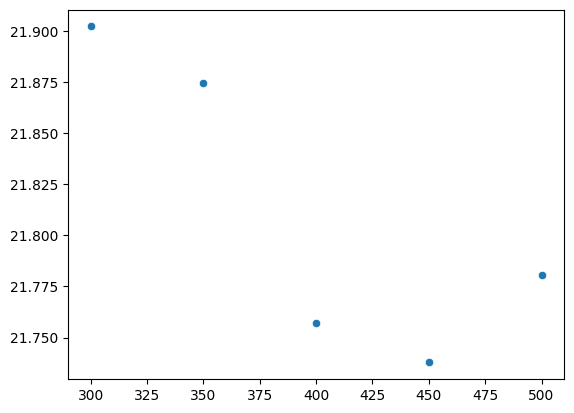

In [214]:
sns.scatterplot(x=max_iters,
y=mses)

plt.show()

These values look good to use.

In [215]:
best_hgb_params = {'learning_rate': 0.2, 'max_depth': 5, 'max_iter': 450}

### 3.5) MLPRegressor

Recall that for neural networks, we need to normalize the X data. This step is included in the grid search function below.

We show the final searches.

In [217]:
def mlp_grid(data, features, hidden_layer_sizes, learning_rates, solvers, print_best=True):

    scale = StandardScaler(copy=True)
    X_scale = scale.fit_transform(data[features])
    grid_cv = GridSearchCV(MLPRegressor(max_iter=10000), 
                          param_grid = {'hidden_layer_sizes': hidden_layer_sizes,
                                        'learning_rate': learning_rates,
                                        'solver': solvers,
                                        }, 
                          scoring = 'neg_mean_squared_error', 
                          cv = 5) 

    grid_cv.fit(X_scale, data['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv

In [ ]:
n_range = np.arange(120, 220, 5)
hidden_layer_sizes = [(n, n) for n in n_range]
learning_rates = ['adaptive']
solvers = ['sgd']

mses = - mlp_grid(concrete_train, features, hidden_layer_sizes, learning_rates, solvers, print_best=True).cv_results_['mean_test_score']


The best set of parameters is {'activation': 'relu', 'hidden_layer_sizes': (165, 165), 'learning_rate': 'adaptive', 'solver': 'sgd'}
The best set of score is 24.859101463511994


In [ ]:
hidden_layer_sizes = [(n, n) for n in np.arange(150, 210, 5)]
learning_rates = ['adaptive']
solvers = ['sgd']

mses = - mlp_grid(concrete_train, features, hidden_layer_sizes, learning_rates, solvers, print_best=True).cv_results_['mean_test_score']


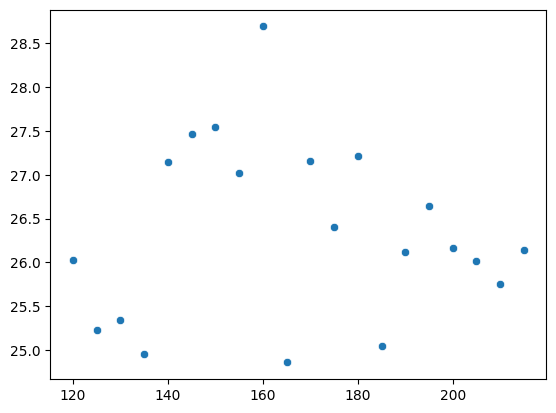

In [ ]:

sns.scatterplot(x=n_range,
                y=mses)

plt.show()

While these values are close to each other, this is a good indication that it is not learning enough to be consistent. We would need more time to try to improve this model. 

In [222]:
best_mlp_params = {'hidden_layer_sizes': (165, 165), 'learning_rate': 'adaptive', 'solver': 'sgd'}

### 3.6) Keras Model

We first normalize the data.

In [ ]:
X_train, y_train = scale.fit_transform(concrete_train[features]), concrete_train['strength']

concrete_tt, concrete_val = train_test_split(concrete_train,
                                             shuffle=True,
                                             random_state=453)

X_tt, y_tt = scale.fit_transform(concrete_tt[features]), concrete_tt['strength']
X_val, y_val = scale.fit_transform(concrete_val[features]), concrete_val['strength']

For keras, we mostly tinkered with the number of layers and epochs and layer sizes. We only include the latest search, since this also had issues converging.

In [126]:

n_range = np.arange(100, 210, 50)
n_splits = 5

kfold = KFold(n_splits=n_splits,
              shuffle=True,
              random_state=29
              )
scale = StandardScaler(copy=True)

n_epochs = 400
keras_mses = np.zeros((n_splits, len(n_range)))
best_epochs = np.zeros((n_splits, len(n_range)))
i = 0
for train_index, test_index in kfold.split(concrete_train):
    print(i)
    concrete_tt, concrete_ho = concrete_train.iloc[train_index], concrete_train.iloc[test_index]
    
    X_tt, y_tt = scale.fit_transform(concrete_tt[features]), concrete_tt['strength']
    X_ho, y_ho = scale.fit_transform(concrete_ho[features]), concrete_ho['strength']
    j = 0
    for layer_size in n_range:
        model1 = Sequential()
        model1.add(layers.Dense(layer_size, activation='relu', input_shape=(X_tt.shape[1],)))
        model1.add(layers.Dense(layer_size, activation='relu'))
        model1.add(layers.Dense(layer_size, activation='relu'))
        model1.add(layers.Dense(layer_size, activation='relu'))
        model1.add(layers.Dense(1, activation='relu'))

        model1.compile(optimizer = 'rmsprop',
                        loss = 'mean_squared_error',
                        metrics = ['mse'])
        history1 = model1.fit(X_tt,
                            y_tt,
                            epochs = n_epochs,
                            batch_size = 50,
                            verbose=0,
                            validation_data = (X_ho, 
                                                y_ho))

        keras_mses[i, j] = np.min(history1.history['val_mse'])
        best_epochs[i, j] = np.argmin(history1.history['val_mse'])
        j += 1
    
    i += 1

np.mean(keras_mses, 0)

0
1
2
3
4


array([25.39137611, 24.1136507 , 23.28960133])

We find that n = 200 is best here, with 400 epochs and 5 layers.

### 3.7) Comparing models

We compare all our models side by side to decide which is best to use. Note that the mse values are different here than in the individual sections since we are using kfold instead of `GridSearchCV`.

In [227]:
layer_size = 200
n_epochs = 400

kfold = KFold(5,

              shuffle=True,
              random_state=29)
              
model_mses=np.zeros((5, 6))

i = 0
    # cross-validation
for train_index, test_index in kfold.split(concrete_train):

    print(i)
    
    concrete_tt = concrete_train.iloc[train_index]
    concrete_ho = concrete_train.iloc[test_index]

    X_tt, y_tt = scale.fit_transform(concrete_tt[features]), concrete_tt['strength']
    X_ho, y_ho = scale.fit_transform(concrete_ho[features]), concrete_ho['strength']
        
    slr = LinearRegression(copy_X=True)
    slr.fit(concrete_tt[features], y_tt)
    slr_pred = slr.predict(concrete_ho[features])

    model_mses[i, 0] = mean_squared_error(y_true=y_ho,
                                        y_pred=slr_pred)

    rf = RandomForestRegressor(max_depth=best_rf_params['max_depth'],
                            n_estimators=best_rf_params['n_estimators'])
    rf.fit(concrete_tt[features], y_tt)
    rf_pred = rf.predict(concrete_ho[features])

    model_mses[i, 1] = mean_squared_error(y_true=y_ho,
                                        y_pred=rf_pred)
        
    xgb = XGBRegressor(max_depth=best_xgb_params['max_depth'], 
                    n_estimators=best_xgb_params['n_estimators'], 
                    tree_method=best_xgb_params['tree_method'])
    xgb.fit(concrete_tt[features], y_tt)
    xgb_pred = xgb.predict(concrete_ho[features])

    model_mses[i, 2] = mean_squared_error(y_true=y_ho,
                                        y_pred=xgb_pred)
                                        
    hgb = HistGradientBoostingRegressor(max_depth=best_hgb_params['max_depth'], 
                                    max_iter=best_hgb_params['max_iter'], 
                                    learning_rate=best_hgb_params['learning_rate'])
    hgb.fit(concrete_tt[features], y_tt)
    hgb_pred = hgb.predict(concrete_ho[features])

    model_mses[i, 3] = mean_squared_error(y_true=y_ho,
                                        y_pred=hgb_pred)
        
    mlp = MLPRegressor(max_iter=10000, 
                    hidden_layer_sizes=best_mlp_params['hidden_layer_sizes'], 
                    learning_rate=best_mlp_params['learning_rate'], 
                    solver=best_mlp_params['solver'])
    mlp.fit(X_tt, y_tt)
    mlp_pred = mlp.predict(X_ho)

    model_mses[i, 4] = mean_squared_error(y_true=y_ho,
                                        y_pred=mlp_pred)
        

    kr = Sequential()
    kr.add(layers.Dense(layer_size, activation='relu', input_shape=(X_tt.shape[1],)))
    kr.add(layers.Dense(layer_size, activation='relu'))
    kr.add(layers.Dense(layer_size, activation='relu'))
    kr.add(layers.Dense(layer_size, activation='relu'))
    kr.add(layers.Dense(1, activation='relu'))

    kr.compile(optimizer = 'rmsprop',
                    loss = 'mean_squared_error',
                    metrics = ['mse'])
    history = kr.fit(X_tt,
                        y_tt,
                        epochs = n_epochs,
                        batch_size = 50,
                        verbose=0,
                        validation_data = (X_ho, 
                                            y_ho))
    kr_pred = kr.predict(X_ho,
                        verbose=0)

    model_mses[i, 5] = mean_squared_error(y_true=y_ho,
                                        y_pred=kr_pred)
                                        

    i += 1

np.mean(model_mses, axis=0)

0
1
2
3
4


In [ ]:
mse_dict = {'Linear': 47.71555271,
'Random Forest': 30.4992049,
'XGBoost': 22.29636623,
'HGBoost': 23.68998024,
'MLP': 31.66170405,
'keras': 27.14812607}

We see that the best model is probably XGBoost, so we will work on fine-tuning it.

## 4) Tuning the best model

We look at more parameters for comparison.

Below is the new grid search function.

In [ ]:
def xgb_grid2(data, features, max_depths, n_estimators, tree_methods, grow_policies, learning_rates, print_best=True):

    grid_cv = GridSearchCV(XGBRegressor(),
                              param_grid = {'max_depth':max_depths, 
                                            'n_estimators':n_estimators,
                                            'tree_method': tree_methods,
                                            'grow_policy': grow_policies,
                                            'learning_rate': learning_rates}, 
                              scoring = 'neg_mean_squared_error', 
                              cv = 5,
                              verbose=4) 

    ## you fit it just like a model
    grid_cv.fit(data[features], data['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv

In [ ]:
max_depths = range(2, 11)
n_estimators = np.arange(500, 2001, 50)
tree_methods = ['approx', 'hist']
grow_policies = [0, 1]
learning_rates = [.01, .1, .2, .3]



grid_cv = xgb_grid(concrete_train, features, max_depths, n_estimators, tree_methods, print_best=True)

KeyboardInterrupt: 

In [ ]:
best_params = {'max_depth': 2, 'n_estimators': 1250, 'tree_method': 'approx'}
best_model = XGBRegressor(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], tree_method=best_params['tree_method'])

best_model.fit(concrete_train[features], concrete_train['strength'])

concrete_train['predict'] = best_model.predict(concrete_train[features])

concrete_test['predict'] = best_model.predict(concrete_test[features])

## 5) Testing the model

Now that we've fine-tuned the XGBoost model, we can try it on the test data.

In [ ]:
best_params = {'max_depth': 2, 'n_estimators': 1200, 'tree_method': 'approx'}
best_model = XGBRegressor(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], tree_method=best_params['tree_method'])
best_model.fit(concrete_train[features], concrete_train['strength'])
concrete_train['predict'] = best_model.predict(concrete_train[features])
concrete_test['predict'] = best_model.predict(concrete_test[features])

In [ ]:
mean_squared_error(concrete_train['strength'], concrete_train['predict'])

In [ ]:
sns.scatterplot(x=concrete_train['cement'],
y=concrete_train['strength'])

sns.scatterplot(x=concrete_train['cement'],
y=concrete_train['predict'])
plt.show()

## 6) Conclusion

This model fits very well with the test data